# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
train_doc = np.random.permutation(open('/content/gdrive/My Drive/Colab Notebooks/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/My Drive/Colab Notebooks/Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image,(100,100))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        remaining = len(t) % batch_size
        print(remaining)
        if remaining != 0:
            batch_data = np.zeros((remaining,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image,(100,100))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/train'
val_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 - Conv3D

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras import optimizers
import keras

#write your model here

model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))


model.add(Conv3D(32, (3, 3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))



model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
learning_rate = 0.001
optimiser = keras.optimizers.Adam(lr=learning_rate) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 50, 50, 32)     1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [12]:
steps_per_epoch

42

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16
Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 3.4396 - categorical_accuracy: 0.2787Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
4
42/42 [==============================] - 143s 3s/step - loss: 3.4218 - categorical_accuracy: 0.2800 - val_loss: 2.1616 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2021-06-2808_41_53.813509/model-00001-2.67702-0.33333-2.16160-0.35000.h5
Epoch 2/10
42/42 [==============================] - 163s 4s/step - loss: 1.8511 - categorical_accuracy: 0.4324 - val_loss: 2.4297 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2021-06-2808_41_53.813509/model-00002-1.77229-0.46305-2.42970-0.24000.h5
Epoch 3/10
42/42 [==============================] - 120s 3s/step - loss: 1.6034 - categorical_accuracy: 0.4936 - val_loss: 2.1839 - val_categorical_accuracy: 0.27

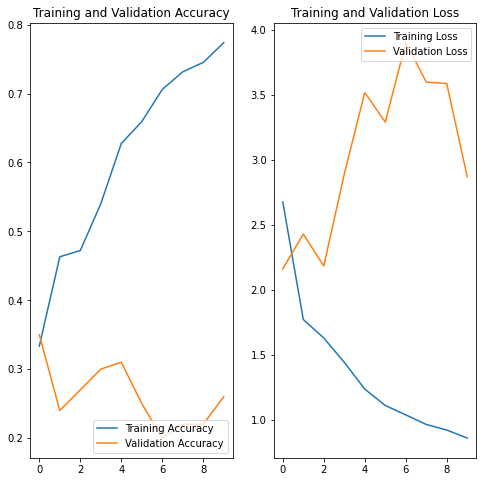

In [14]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 2 - Conv3D

- Increasing the number of epochs.
- Increading the dropout.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/train'
val_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

model2 = Sequential()
model2.add(Conv3D(16, (3,3,3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2,2)))
model2.add(Dropout(0.3))

model2.add(Conv3D(32, (3, 3,3), padding='same'))
model.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2,2)))
model2.add(Dropout(0.3))

model2.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2,2)))
model2.add(Dropout(0.3))


model2.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(128,kernel_regularizer=l2(0.01)))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))

model2.add(Dense(5))
model2.add(Activation('softmax'))

learning_rate = 0.001
optimiser = keras.optimizers.Adam(lr=learning_rate) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 30
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_7 (Activation)    (None, 7, 50, 50, 32)     0         
__________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 4.1079 - categorical_accuracy: 0.2120Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
4
42/42 [==============================] - 120s 3s/step - loss: 4.0950 - categorical_accuracy: 0.2116 - val_loss: 2.8469 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2021-06-2809_02_55.385154/model-00001-3.55404-0.19608-2.84690-0.22000.h5
Epoch 2/30
42/42 [==============================] - 119s 3s/step - loss: 2.6521 - categorical_accuracy: 0.2214 - val_loss: 2.2114 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2021-06-2809_02_55.385154/model-00002-2.50102-0.22474-2.21136-0.21000.h5
Epoch 3/30
42/42 [==============================] - 116s 3s/step - loss: 2.0954 - categorical_accuracy: 0.2434 - val_loss: 1.7476 - val_categorical_accuracy: 0.3700

Epoch 00003: saving model to model_init_2021-06-2809_02_55.385154/model-00003-2.01348-0.2

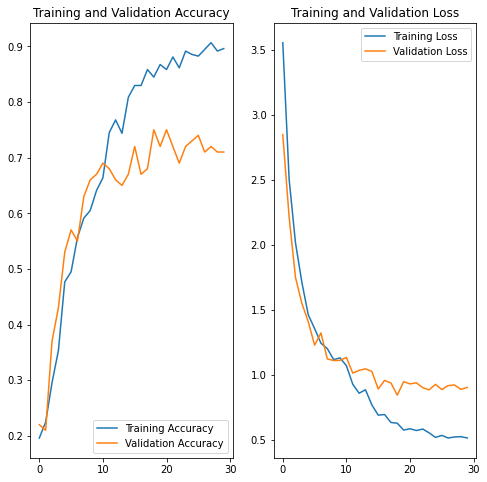

In [17]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 3 - Conv3D

- Adding l2 regularisation to avoid overfitting.
- Increasing dropout and number of epochs to increase the stability.


In [18]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/train'
val_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

model3 = Sequential()
model3.add(Conv3D(16, (3,3,3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2,2)))
model3.add(Dropout(0.3))


model3.add(Conv3D(32, (3, 3,3), padding='same'))
model.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2,2)))
model3.add(Dropout(0.3))

model3.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2,2)))
model3.add(Dropout(0.3))



model3.add(Flatten())
model3.add(Dense(64,kernel_regularizer=l2(0.1)))
model3.add(Activation('relu'))
model3.add(Dropout(0.4))
model3.add(Dense(128,kernel_regularizer=l2(0.01)))
model3.add(Activation('relu'))
model3.add(Dropout(0.4))

model3.add(Dense(5))
model3.add(Activation('softmax'))

learning_rate = 0.001
optimiser = keras.optimizers.Adam(lr=learning_rate) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 40
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_13 (Activation)   (None, 7, 50, 50, 32)     0         
__________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


history3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
42/42 [==============================] - ETA: 0s - loss: 9.9229 - categorical_accuracy: 0.2051 Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
4
42/42 [==============================] - 121s 3s/step - loss: 9.8446 - categorical_accuracy: 0.2053 - val_loss: 2.7011 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2021-06-2810_02_53.505325/model-00001-6.55538-0.21116-2.70113-0.32000.h5
Epoch 2/40
42/42 [==============================] - 120s 3s/step - loss: 2.4452 - categorical_accuracy: 0.2537 - val_loss: 2.0171 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2021-06-2810_02_53.505325/model-00002-2.29234-0.25490-2.01713-0.36000.h5
Epoch 3/40
42/42 [==============================] - 121s 3s/step - loss: 2.0027 - categorical_accuracy: 0.2713 - val_loss: 1.8819 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2021-06-2810_02_53.505325/model-00003-1.95391-0.

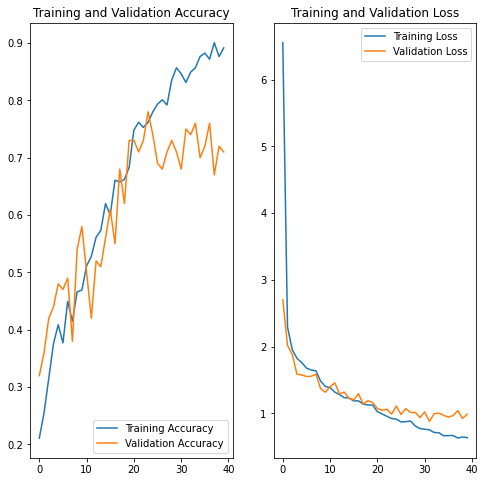

In [20]:
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 4 - MobileNet + GRU

In [31]:
from keras.applications.mobilenet import MobileNet

In [32]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16


(15, 100, 100, 3)

In [37]:
from tensorflow.keras.layers import MaxPooling2D

curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/train'
val_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

mobilenet_TL = MobileNet(weights='imagenet', include_top=False)

model4 = Sequential()
model4.add(TimeDistributed(mobilenet_TL, input_shape = inputShape))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(Flatten()))

model4.add(GRU(64))
model4.add(Dropout(0.3))

model4.add(Dense(64,activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(5, activation='softmax'))

learning_rate = 0.001
optimiser = keras.optimizers.Adam(lr=learning_rate) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 10
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 9216)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                1782144   
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [38]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


history4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 1.4649 - categorical_accuracy: 0.3938Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
4
42/42 [==============================] - 149s 3s/step - loss: 1.4605 - categorical_accuracy: 0.3960 - val_loss: 1.2298 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2021-06-2811_44_05.496959/model-00001-1.27281-0.49020-1.22978-0.53000.h5
Epoch 2/10
42/42 [==============================] - 121s 3s/step - loss: 0.6914 - categorical_accuracy: 0.7337 - val_loss: 0.8872 - val_categorical_accuracy: 0.6800

Epoch 00002: saving model to model_init_2021-06-2811_44_05.496959/model-00002-0.62152-0.78733-0.88720-0.68000.h5
Epoch 3/10
42/42 [==============================] - 120s 3s/step - loss: 0.4132 - categorical_accuracy: 0.8731 - val_loss: 0.3983 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2021-06-2811_44_05.496959/model-00003-0.39532-0.8

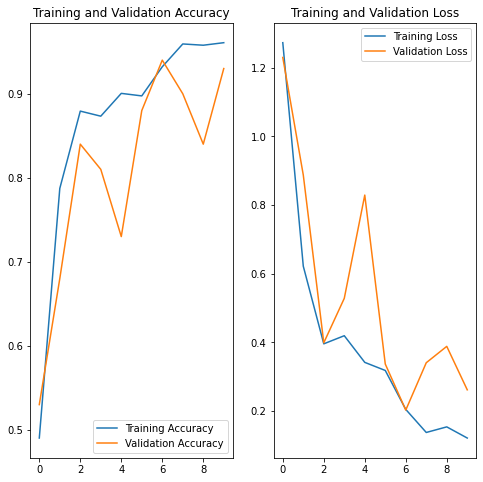

In [39]:
acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 5 - MobileNet + GRU

- Will experiment by removing the dropout.
- Increasing the number of epochs for training the model more.

In [40]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/train'
val_path = '/content/gdrive/My Drive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

mobilenet_TL = MobileNet(weights='imagenet', include_top=False)

model5 = Sequential()
model5.add(TimeDistributed(mobilenet_TL,input_shape= inputShape))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(Flatten()))

model5.add(GRU(64))
model5.add(Dropout(0.3))

model5.add(Dense(64,activation='relu'))

model5.add(Dense(5, activation='softmax'))

learning_rate = 0.001
optimiser = keras.optimizers.Adam(lr=learning_rate) #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 9216)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                1782144   
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [41]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.3769 - categorical_accuracy: 0.4410Source path =  /content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
4
42/42 [==============================] - 139s 3s/step - loss: 1.3693 - categorical_accuracy: 0.4444 - val_loss: 1.5018 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2021-06-2812_06_14.499404/model-00001-1.04976-0.58673-1.50176-0.44000.h5
Epoch 2/20
42/42 [==============================] - 121s 3s/step - loss: 0.4796 - categorical_accuracy: 0.8276 - val_loss: 0.8771 - val_categorical_accuracy: 0.7100

Epoch 00002: saving model to model_init_2021-06-2812_06_14.499404/model-00002-0.46584-0.83409-0.87710-0.71000.h5
Epoch 3/20
42/42 [==============================] - 122s 3s/step - loss: 0.3413 - categorical_accuracy: 0.8824 - val_loss: 0.7716 - val_categorical_accuracy: 0.7100

Epoch 00003: saving model to model_init_2021-06-2812_06_14.499404/model-00003-0.37941-0.8

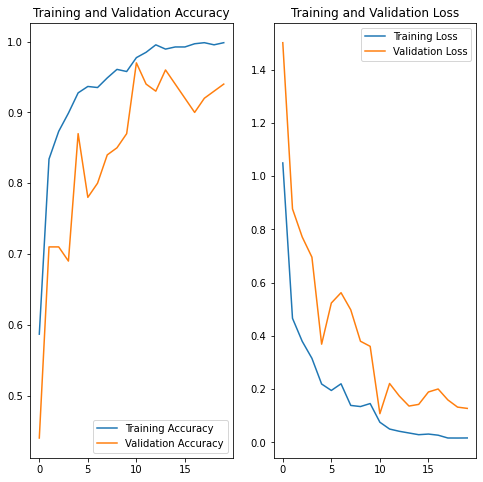

In [42]:
acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()